# THE BATTLE OF NEIGHBORHOODS

## Applied Data Science Capstone by IBM avaliable on Coursera

##### This notebook contains the code for the final project - THE BATTLE OF THE NEIGHBORHOODS.

#### Installing all the required Libraries. 

In [1]:
!pip install BeautifulSoup4
!pip install geopy
!pip install geocoder
!pip install matplotlib
!pip install folium
!pip install lxml
print("INSTALLED ALL LIBRARIES")

     |████████████████████████████████| 122kB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 5.5MB/s eta 0:00:01
     |████████████████████████████████| 102kB 6.2MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
     |████████████████████████████████| 829kB 6.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 5.5MB 3.1MB/s eta 0:00:01
INSTALLED ALL LIBRARIES


#### Importing the required libraries

In [2]:
import numpy as np
import geocoder

import pandas as pd

import json

from geopy.geocoders import Nominatim

import requests
import random
from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

import folium

import lxml.html as lh

from IPython.display import Image 
from IPython.core.display import HTML

print('All required libraries were imported!')

All required libraries were imported!


#### Defining Foursquare Credentials and Version

In [61]:
CLIENT_ID = 'U010Q3P3ZN5OGXQ2LXJDHOXTRKQ3QMOV4HC5JQ34TDUSDLST'
CLIENT_SECRET = 'AGQUGZECSF3ZUMDFXASHDYQYQVISVW5B0IT4OEISXHMGCJPR'
VERSION = '20180604'
LIMIT = 30
print('Your credentials:')
print('CLIENT_ID:'+CLIENT_ID)
print('CLIENT_SECRET:'+CLIENT_SECRET)

Your credentials:
CLIENT_ID:U010Q3P3ZN5OGXQ2LXJDHOXTRKQ3QMOV4HC5JQ34TDUSDLST
CLIENT_SECRET:AGQUGZECSF3ZUMDFXASHDYQYQVISVW5B0IT4OEISXHMGCJPR


## Extracting a real world dataset from Kaggle showing crimes in London

#### Reading the Dataset

In [3]:
# Reading the downloaded data(in .csv format) to a dataframe
df = pd.read_csv("london_crime_by_lsoa.csv")

In [4]:
# Displaying the top 5 rows of the dataframe to verify if it has been read properly
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


#### Cleaning the dataset

In [5]:
# Taking the values of the most recent year(2016) and dropping the remaining values
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the reading for which crime values have not been recorded
df = df[df.value != 0]

# Dropping the previous index and rest to new index
df = df.reset_index(drop = True)

In [6]:
# Shape of the dataframe
df.shape

(392042, 7)

In [7]:
# Top 5 rows of the new dataframe
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


#### Changing the column names

In [8]:
df.columns = ['LSOA_Code', 'Borough', 'Major_Category', 'Minor_Category', 'No_of_Crimes', 'Year', 'Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [9]:
# Detailed information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA_Code       392042 non-null  object
 1   Borough         392042 non-null  object
 2   Major_Category  392042 non-null  object
 3   Minor_Category  392042 non-null  object
 4   No_of_Crimes    392042 non-null  int64 
 5   Year            392042 non-null  int64 
 6   Month           392042 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


#### To know the number of crimes in each Borough

In [10]:
df['Borough'].value_counts()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

#### TO know what type of crime has been committed most number of times

In [11]:
df['Major_Category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: Major_Category, dtype: int64

#### Pivoting the table to understand the number of crimes for each major category in each borough 

In [12]:
London_crime = pd.pivot_table(df, values=['No_of_Crimes'],
                             index = ['Borough'],
                             columns = ['Major_Category'],
                             aggfunc = np.sum, fill_value = 0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [13]:
# Reset the index
London_crime.reset_index(inplace = True)

In [14]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(10)

Borough No_of_Crimes                        \
Major_Category                           Burglary Criminal Damage Drugs   
0               Barking and Dagenham         1287            1949   919   
1                             Barnet         3402            2183   906   
2                             Bexley         1123            1673   646   
3                              Brent         2631            2280  2096   
4                            Bromley         2214            2202   728   
5                             Camden         2652            1935  1493   
6                     City of London            2               2    10   
7                            Croydon         2738            3219  1367   
8                             Ealing         2492            2562  1355   
9                            Enfield         2541            2136  1063   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   
5                                    490     899              14088   
6                                      6       4                129   
7                                    718    1139               9229   
8                                    613     669              10040   
9                                    492     807               8037   

                                            Total  
Major_Category Violence Against the Person         
0                                     6067  16741  
1                                     7499  24684  
2                                     4503  12840  
3                                     9205  26693  
4                                     6650  20164  
5                                     7626  29183  
6                                       25    178  
7                                    10302  28712  
8                                     9396  27127  
9                                     7409  22485

#### Cleaning the table to make merging easier

In [15]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [16]:
# Shape of the dataset
London_crime.shape

(33, 9)

## Extracting additional information about London from Wikipedia

#### Using BeautifulSoup to extract the latitude and longitude values

In [17]:
# Extracting data from wikipedia
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page = requests.get(wikipedia_link).text

# Using BeautifulSoup to parse the HTML/XML codes
soup = BeautifulSoup(raw_wikipedia_page, 'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"87fd4169-b10f-4a0c-bfb0-b54f2c99cab6","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":958873870,"wgRevisionId":958873870,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of 

In [18]:
# Extracting the raw table
table = soup.find_all('table',{'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

#### Reading the table into a dataframe

In [19]:
London_table = pd.read_html(str(table[0]), index_col = None, header = 0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [20]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
27,Sutton,NaN,NaN,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,18
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2


#### Detailed information about the dataframe

In [21]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   32 non-null     object 
 1   Inner                     3 non-null      object 
 2   Status                    4 non-null      object 
 3   Local authority           32 non-null     object 
 4   Political control         32 non-null     object 
 5   Headquarters              32 non-null     object 
 6   Area (sq mi)              32 non-null     float64
 7   Population (2013 est)[1]  32 non-null     int64  
 8   Co-ordinates              32 non-null     object 
 9   Nr. in map                32 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.6+ KB


#### Cleaning the dataframe

In [22]:
London_table = London_table.replace('note 1', '', regex = True)
London_table = London_table.replace('note 2', '', regex = True)
London_table = London_table.replace('note 3', '', regex = True)
London_table = London_table.replace('note 4', '', regex = True)
London_table = London_table.replace('note 5', '', regex = True)

London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [23]:
# Displaying the type of the table
type(London_table)

pandas.core.frame.DataFrame

In [24]:
# Shape of the dataframe
London_table.shape

(32, 10)

#### Merging the tables 

In [25]:
Ld_crime = pd.merge(London_crime, London_table, on = 'Borough')
Ld_crime.head(10)

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
1,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
2,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
3,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
4,Camden,2652,1935,1493,490,899,14088,7626,29183,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
5,Croydon,2738,3219,1367,718,1139,9229,10302,28712,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
6,Ealing,2492,2562,1355,613,669,10040,9396,27127,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
7,Enfield,2541,2136,1063,492,807,8037,7409,22485,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
8,Hackney,2719,1981,1353,499,1030,11851,8832,28265,NaN,NaN,Hackney London Borough Council,Labour,"Hackney Town Hall, Mare Street",7.36,257379,51°32′42″N 0°03′19″W﻿ / ﻿51.5450°N 0.0553°W,9
9,Haringey,2474,2233,1540,551,1248,10554,8574,27174,[],NaN,Haringey London Borough Council,Labour,"Civic Centre, High Road",11.42,263386,51°36′00″N 0°06′43″W﻿ / ﻿51.6000°N 0.1119°W,29


In [26]:
Ld_crime.shape

(29, 18)

In [32]:
set(df.Borough) - set(Ld_crime.Borough)

{'City of London'}

In [27]:
list(Ld_crime)

['Borough',
 'No_of_CrimesBurglary',
 'No_of_CrimesCriminal Damage',
 'No_of_CrimesDrugs',
 'No_of_CrimesOther Notifiable Offences',
 'No_of_CrimesRobbery',
 'No_of_CrimesTheft and Handling',
 'No_of_CrimesViolence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

## Detailed analysis of the data

#### Statistics of the table

In [28]:
London_crime.describe()

,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2069.242424,1941.545455,1179.212121,479.060606,682.666667,8913.121212,7041.848485,22306.696970
std,737.448644,625.207070,586.406416,223.298698,441.425366,4620.565054,2513.601551,8828.228749
min,2.000000,2.000000,10.000000,6.000000,4.000000,129.000000,25.000000,178.000000
25%,1531.000000,1650.000000,743.000000,378.000000,377.000000,5919.000000,5936.000000,16903.000000
50%,2071.000000,1989.000000,1063.000000,490.000000,599.000000,8925.000000,7409.000000,22730.000000
75%,2631.000000,2351.000000,1617.000000,551.000000,936.000000,10789.000000,8832.000000,27174.000000
max,3402.000000,3219.000000,2738.000000,1305.000000,1822.000000,27520.000000,10834.000000,48330.000000


In [29]:
# To generate plots within the browser
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

print('Matplotlib version:', mpl.__version__)

import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version: 3.1.1


#### Checking what is the type of column names 

In [30]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

all(isinstance(column, str) for column in Ld_crime.columns)

True

#### Sorting the table to identify the top five areas with most number of crimes

In [31]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True)
df_top5 = Ld_crime.head()
df_top5

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Westminster,3218,2179,2049,708,1822,27520,10834,48330,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
17,Lambeth,3087,2764,2738,635,1196,13155,10496,34071,NaN,NaN,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,6
23,Southwark,2946,2621,1838,494,1317,12946,9474,31636,NaN,NaN,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,7
20,Newham,2115,2496,1684,713,1472,11964,9646,30090,[],NaN,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,27
25,Tower Hamlets,2794,2357,1629,678,1234,10953,9608,29253,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8


#### Visualizing the areas with most number of crimes

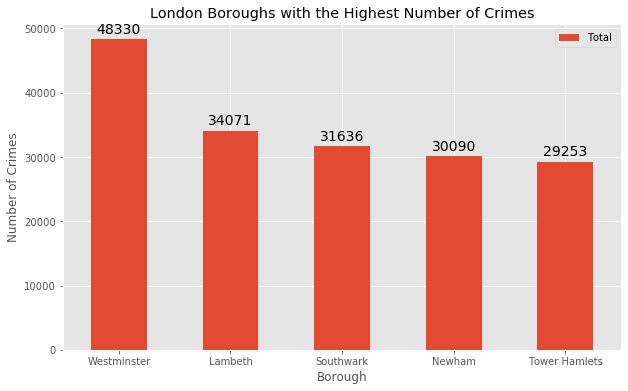

In [32]:
df_tt = df_top5[['Borough', 'Total']]

df_tt.set_index('Borough', inplace = True)

ax = df_tt.plot(kind = 'bar', figsize = (10,6), rot = 0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('London Boroughs with the Highest Number of Crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals = 2),
               (p.get_x()+p.get_width()/2., p.get_height()),
               ha = 'center',
               va = 'center',
               xytext = (0,10),
               textcoords = 'offset points', 
               fontsize = 14)
plt.show()

##### From the graph it is clear that any person or family moving to these places will have to think twice. It would be advisible to avoid these areas. 

#### Sorting the table to identify the top five ares with least number of crimes

In [33]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True)

df_bot5 = Ld_crime.head()
df_bot5

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
16,Kingston upon Thames,879,1054,743,189,121,3803,3194,9983,NaN,Royal,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,16
24,Sutton,1233,1316,461,253,165,3516,3714,10658,NaN,NaN,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,18
22,Richmond upon Thames,1359,1148,320,217,106,4769,3155,11074,NaN,NaN,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,15
19,Merton,1419,1418,466,249,283,4894,4026,12755,NaN,NaN,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,17
1,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23


#### Visualizing the areas with least number of crimes

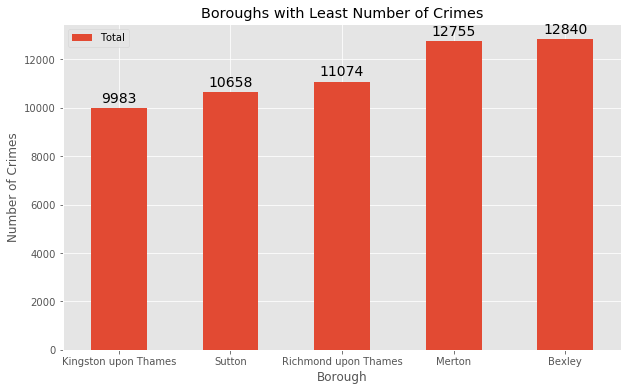

In [34]:
df_bt = df_bot5[['Borough', 'Total']]

df_bt.set_index('Borough', inplace = True)

ax = df_bt.plot(kind = 'bar', figsize = (10,6), rot = 0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs with Least Number of Crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals = 2),
               (p.get_x()+p.get_width()/2., p.get_height()),
               ha = 'center',
               va = 'center',
               xytext = (0,10),
               textcoords = 'offset points',
               fontsize = 14)
plt.show()

##### From the graph we can see that Kingston upon Thames is the area with least number of crimes. Now we will be analyzing Kingston upon Thames in detail.

#### Visualizing 'Kingston upon Thames' in detail

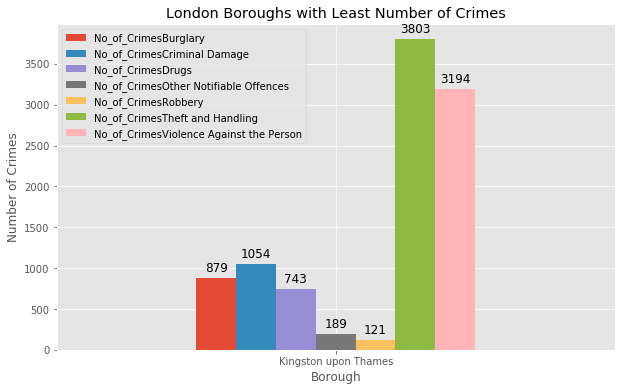

In [35]:
df_bc1 = df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough', 'No_of_CrimesBurglary', 'No_of_CrimesCriminal Damage', 'No_of_CrimesDrugs',
               'No_of_CrimesOther Notifiable Offences', 'No_of_CrimesRobbery', 'No_of_CrimesTheft and Handling',
               'No_of_CrimesViolence Against the Person']]

df_bc.set_index('Borough', inplace = True)

ax = df_bc.plot(kind = 'bar', figsize = (10,6), rot =0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('London Boroughs with Least Number of Crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals = 2),
               (p.get_x()+p.get_width()/2., p.get_height()),
               ha = 'center',
               va = 'center',
               xytext = (0,10),
               textcoords = 'offset points',
               fontsize = 12)
plt.show()

##### As we have mentioned earlier, Kingston upon Thames would be an ideal location for people moving into London.

#### Creating a new dataframe containing the neighborhoods within Kingston upon Thames

In [36]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
               'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton','Old Malden',
               'Seething Wells','Surbiton','Tolworth']
Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames', 'Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh ={'Neighborhood': Neighborhood, 'Borough': Borough, 'Latitude': Latitude, 'Longitude': Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood','Borough','Latitude','Longitude'], index = None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


#### Obtaining the latitude and longitude values of the neighborhoods in Kingston upon Thames

In [37]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{}, London, United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent='London_agent')
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


#### Reading the latitude and longitude values into the table created earlier

In [38]:
df_neigh = {'Neighborhood': Neighborhood, 'Borough': Borough, 'Latitude': Latitude, 'Longitude': Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [39]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent = 'ld_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Berrylands, London are {}, {}'.format(latitude, longitude))

The geographical coordinates of Berrylands, London are 51.3937811, -0.2848024


#### Visualizing the neighborhoods in Kingston upon Thames

In [40]:
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label ='{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_lon)
map_lon    

#### Creating a function to extract venues from each neighborhood

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    venues_list = []
    for name, lat, lng, in zip(names, latitudes, longitudes):
        print(name)
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
             CLIENT_ID,
             CLIENT_SECRET,
             VERSION,
             lat,
             lng,
             radius,
             LIMIT)
        # Using request to extract values from the page
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # To obtain the required values only
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    return(nearby_venues)

In [43]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                            latitudes=kut_neig['Latitude'],
                            longitudes=kut_neig['Longitude']
                            )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [44]:
print(kut_venues.shape)
kut_venues.head()

(170, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,SK Superstores,51.389901,-0.283278,Convenience Store
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [45]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Chessington,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,7,7,7,7,7,7


In [46]:
print('There are {} unique categories'.format(len(kut_venues['Venue Category'].unique())))

There are 73 unique categories


#### Onehot encoding for clustering

In [47]:
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

kut_onehot['Neighborhood'] = kut_venues['Neighborhood']

fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Seafood Restaurant,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping the rows by taking mean of the frequency of occurance  

In [48]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Seafood Restaurant,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.071429,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000
2,Chessington,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000
6,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.037037,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037037,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000


In [49]:
kut_grouped.shape

(14, 74)

In [50]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0     Convenience Store  0.25
1              Bus Stop  0.25
2                  Park  0.25
3  Gym / Fitness Center  0.25
4     Indian Restaurant  0.00


----Canbury----
   venue  freq
0    Pub  0.29
1  Plaza  0.07
2   Café  0.07
3   Park  0.07
4  Hotel  0.07


----Chessington----
              venue  freq
0  Business Service   1.0
1  Asian Restaurant   0.0
2            Market   0.0
3       Pizza Place   0.0
4          Pharmacy   0.0


----Hook----
               venue  freq
0             Bakery  0.25
1  Indian Restaurant  0.25
2        Supermarket  0.25
3  Fish & Chips Shop  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
                       venue  freq
0              Grocery Store  0.25
1                        Bar  0.25
2               Soccer Field  0.25
3             Sandwich Place  0.25
4  Latin American Restaurant  0.00


----Kingston upon Thames----
              venue  freq
0              Café  0.10
1       Coffee Shop  

#### Creating a dataframe containing the values

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Creating the columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# Creating new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Bus Stop,Convenience Store,Train Station,Farmers Market,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store
1,Canbury,Pub,Plaza,Park,Supermarket,Spa,Fish & Chips Shop,Shop & Service,Café,Gym / Fitness Center,Hotel
2,Chessington,Business Service,Train Station,Convenience Store,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
3,Hook,Indian Restaurant,Fish & Chips Shop,Supermarket,Bakery,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
4,Kingston Vale,Grocery Store,Bar,Soccer Field,Sandwich Place,Furniture / Home Store,Fried Chicken Joint,Garden Center,Gastropub,French Restaurant,Food


#### K-Means clustering to cluster the similar neighborhoods 

In [53]:
# Importing KMeans
from sklearn.cluster import KMeans

# Setting number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# Running KMeans clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# Checking is cluster labels were created
kmeans.labels_[0:10]

array([0, 4, 3, 2, 1, 4, 1, 0, 4, 4], dtype=int32)

In [54]:
# Adding cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# Merging the two tables so as to abtain latitude/longitude values for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,0.0,Gym / Fitness Center,Park,Bus Stop,Convenience Store,Train Station,Farmers Market,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store
1,Canbury,Kingston upon Thames,51.417499,-0.305553,4.0,Pub,Plaza,Park,Supermarket,Spa,Fish & Chips Shop,Shop & Service,Café,Gym / Fitness Center,Hotel
2,Chessington,Kingston upon Thames,51.358336,-0.298622,3.0,Business Service,Train Station,Convenience Store,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,2.0,Indian Restaurant,Fish & Chips Shop,Supermarket,Bakery,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


In [55]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          14 non-null     float64
 5   1 Most Common Venue     14 non-null     object 
 6   2 Most Common Venue     14 non-null     object 
 7   3 Most Common Venue     14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [56]:
# Dropping the row with 'NaN' value
kut_merged.dropna(inplace=True)

In [57]:
kut_merged.shape

(14, 15)

In [58]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [59]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            14 non-null     object 
 1   Borough                 14 non-null     object 
 2   Latitude                14 non-null     float64
 3   Longitude               14 non-null     float64
 4   Cluster Labels          14 non-null     int64  
 5   1 Most Common Venue     14 non-null     object 
 6   2 Most Common Venue     14 non-null     object 
 7   3 Most Common Venue     14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

#### Visualizing the clusters

In [60]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + 'Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
       [lat, lon],
       radius = 8,
       popup = label,
       color = rainbow[cluster-1],
       fill = True,
       fill_color = rainbow[cluster-1],
       fill_opacity = 0.5).add_to(map_clusters)
map_clusters

### Examining each cluster 

#### Cluster One

In [83]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0,Pub,Café,Gym / Fitness Center,Supermarket,Spa,Shop & Service,Fish & Chips Shop,Park,Hotel,Indian Restaurant
4,Hook,Kingston upon Thames,51.367898,-0.307145,0,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,French Restaurant,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Food
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,0,Café,Burger Joint,Sushi Restaurant,Coffee Shop,Pub,Asian Restaurant,German Restaurant,Gift Shop,French Restaurant,Electronics Store
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,0,Grocery Store,Garden Center,Pub,Restaurant,Wine Shop,Fast Food Restaurant,Department Store,Dry Cleaner,Electronics Store,Farmers Market
9,New Malden,Kingston upon Thames,51.405335,-0.263407,0,Gastropub,Sushi Restaurant,Supermarket,Bar,Chinese Restaurant,Indian Restaurant,Korean Restaurant,Wine Shop,Fish & Chips Shop,Dry Cleaner
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,0,Indian Restaurant,Pub,Food,Italian Restaurant,Platform,Wine Shop,Farmers Market,Dry Cleaner,Hardware Store,Hotel
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,0,Indian Restaurant,Coffee Shop,Pub,Gym,Pet Café,Fast Food Restaurant,Playground,Chinese Restaurant,Italian Restaurant,Café
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,0,Coffee Shop,Pub,Italian Restaurant,Pharmacy,Grocery Store,Gym / Fitness Center,Breakfast Spot,Deli / Bodega,Gastropub,Hotel
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,0,Grocery Store,Pizza Place,Restaurant,Train Station,Hotel,Indian Restaurant,Italian Restaurant,Pharmacy,Coffee Shop,Café


##### Out of the 13 neighborhoods, 9 neighborhoods fall in cluster ONE. Indian families would prefer these areas as there are a few Indian reataurants in the area. There are ample number of supermarkets, grocery stores, parks, gym, etc. This would be an ideal place for a family planning to move to London. But, before we finalize, lets take a look at the remaining clusters. 

#### Cluster Two

In [84]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,1,Health & Beauty Service,Wine Shop,Food,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,French Restaurant


##### This neighborhood looks good. Farmers market is close-by. But other than that we don't see any other essential place. Cluster ONE is a better final result than Cluster TWO. 

#### Cluster Three

In [85]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,2,Grocery Store,Food,Construction & Landscaping,Train Station,German Restaurant,Gastropub,Garden Center,Furniture / Home Store,Fried Chicken Joint,Deli / Bodega


##### Grocery store and train stations are nearby. But not better result than cluster ONE.

#### Cluster Four

In [86]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Food,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,3,Gym,Park,Bus Stop,Soccer Field,Restaurant,Fast Food Restaurant,Department Store,Dry Cleaner,Electronics Store,Farmers Market


##### This would the SECOND best cluster. Better result compared to cluster TWO & THREE, but not better than ONE. 

#### Cluster Five

In [87]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.43185,-0.258138,4,Sandwich Place,Grocery Store,Bar,Soccer Field,Wine Shop,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


##### Better than cluster TWO, but not better than the other clusters. 